In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle, joblib
%matplotlib inline
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
sns.set_style('darkgrid')

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.option_context('display.max_rows', 1000)

In [2]:
os.makedirs("beer_rating_files", exist_ok=True)

In [3]:
url = 'https://twoldem-ml.s3.us-east-2.amazonaws.com/beer_reviews.csv'

df = pd.read_csv(url, low_memory= False)

df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [4]:
print(f'We have {df.shape[0]:,} rows')
print(f'We have {df.shape[1]} columns')

We have 1,586,614 rows
We have 13 columns


In [5]:
df[ 'review_time' ] = pd.to_datetime( df[ 'review_time' ], unit = 's' )
df.tail()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
1586609,14359,The Defiant Brewing Company,2006-11-05 00:01:32,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586610,14359,The Defiant Brewing Company,2006-10-17 01:29:26,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586611,14359,The Defiant Brewing Company,2006-10-13 01:21:53,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586612,14359,The Defiant Brewing Company,2006-10-05 04:37:24,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061
1586613,14359,The Defiant Brewing Company,2006-10-04 23:41:59,5.0,4.5,4.5,cbl2,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


# **Data Exploration**

In [6]:
df.dtypes

brewery_id                     int64
brewery_name                  object
review_time           datetime64[ns]
review_overall               float64
review_aroma                 float64
review_appearance            float64
review_profilename            object
beer_style                    object
review_palate                float64
review_taste                 float64
beer_name                     object
beer_abv                     float64
beer_beerid                    int64
dtype: object

In [7]:
# look at categorical variables
for i in df.columns[df.dtypes == object].values:
    print(i, '\n',df[i].unique(), '\n',df[i].nunique(),'\n','*******')

brewery_name 
 ['Vecchio Birraio' 'Caldera Brewing Company' 'Amstel Brouwerij B. V.' ...
 'Wissey Valley Brewery' 'Outback Brewery Pty Ltd'
 'Georg Meinel Bierbrauerei KG'] 
 5742 
 *******
review_profilename 
 ['stcules' 'johnmichaelsen' 'oline73' ... 'hogshead' 'NyackNicky'
 'joeebbs'] 
 33387 
 *******
beer_style 
 ['Hefeweizen' 'English Strong Ale' 'Foreign / Export Stout'
 'German Pilsener' 'American Double / Imperial IPA' 'Herbed / Spiced Beer'
 'Light Lager' 'Oatmeal Stout' 'American Pale Lager' 'Rauchbier'
 'American Pale Ale (APA)' 'American Porter' 'Belgian Strong Dark Ale'
 'American IPA' 'American Stout' 'Russian Imperial Stout'
 'American Amber / Red Ale' 'American Strong Ale' 'Märzen / Oktoberfest'
 'American Adjunct Lager' 'American Blonde Ale' 'Euro Pale Lager'
 'English Brown Ale' 'Scotch Ale / Wee Heavy' 'Fruit / Vegetable Beer'
 'American Double / Imperial Stout' 'Belgian Pale Ale' 'English Bitter'
 'English Porter' 'Irish Dry Stout' 'American Barleywine'
 'Belgian S

It dosent make sense to have a feature/variable with lots of categories. We will keep one's with limited categories only later on.

In [8]:
drop_columns = ['review_profilename', 'review_time']

In [9]:
# df.info(null_counts = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   brewery_id          1586614 non-null  int64         
 1   brewery_name        1586599 non-null  object        
 2   review_time         1586614 non-null  datetime64[ns]
 3   review_overall      1586614 non-null  float64       
 4   review_aroma        1586614 non-null  float64       
 5   review_appearance   1586614 non-null  float64       
 6   review_profilename  1586266 non-null  object        
 7   beer_style          1586614 non-null  object        
 8   review_palate       1586614 non-null  float64       
 9   review_taste        1586614 non-null  float64       
 10  beer_name           1586614 non-null  object        
 11  beer_abv            1518829 non-null  float64       
 12  beer_beerid         1586614 non-null  int64         
dtypes: datetime6

In [10]:
df.columns

Index(['brewery_id', 'brewery_name', 'review_time', 'review_overall', 'review_aroma', 'review_appearance', 'review_profilename', 'beer_style', 'review_palate', 'review_taste', 'beer_name', 'beer_abv', 'beer_beerid'], dtype='object')

In [11]:
#gives back numerical columns only
data_count = df.describe().transpose()
data_count

,count,mean,std,min,25%,50%,75%,max
brewery_id,1586614.0,3130.099202,5578.103987,1.00,143.0,429.0,2372.0,28003.0
review_overall,1586614.0,3.815581,0.720622,0.00,3.5,4.0,4.5,5.0
review_aroma,1586614.0,3.735636,0.697617,1.00,3.5,4.0,4.0,5.0
review_appearance,1586614.0,3.841642,0.616093,0.00,3.5,4.0,4.0,5.0
review_palate,1586614.0,3.743701,0.682218,1.00,3.5,4.0,4.0,5.0
review_taste,1586614.0,3.792860,0.731970,1.00,3.5,4.0,4.5,5.0
beer_abv,1518829.0,7.042387,2.322526,0.01,5.2,6.5,8.5,57.7
beer_beerid,1586614.0,21712.794279,21818.335997,3.00,1717.0,13906.0,39441.0,77317.0


Seems we have missing values only in `beer_abv` in the numerical columns!

In [12]:
df.isnull().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

In [13]:
print( 'Unique breweries' )
print( 'By id:', df[ 'brewery_id' ].nunique() )
print( 'By name:', df[ 'brewery_name' ].nunique() )

Unique breweries
By id: 5840
By name: 5742


Seems brewery_name and brewery_id are the same, lets drop one of them. We choose the brewery_name since it already has missing items

In [14]:
drop_columns.append('brewery_name')

In [15]:
print( 'Unique beers' )
print( 'By id:', df[ 'beer_beerid' ].nunique() )
print( 'By name:', df[ 'beer_name' ].nunique() )

Unique beers
By id: 66055
By name: 56857


We will go with beer name since we are getting more ids for same names

In [16]:
drop_columns.append('beer_beerid')

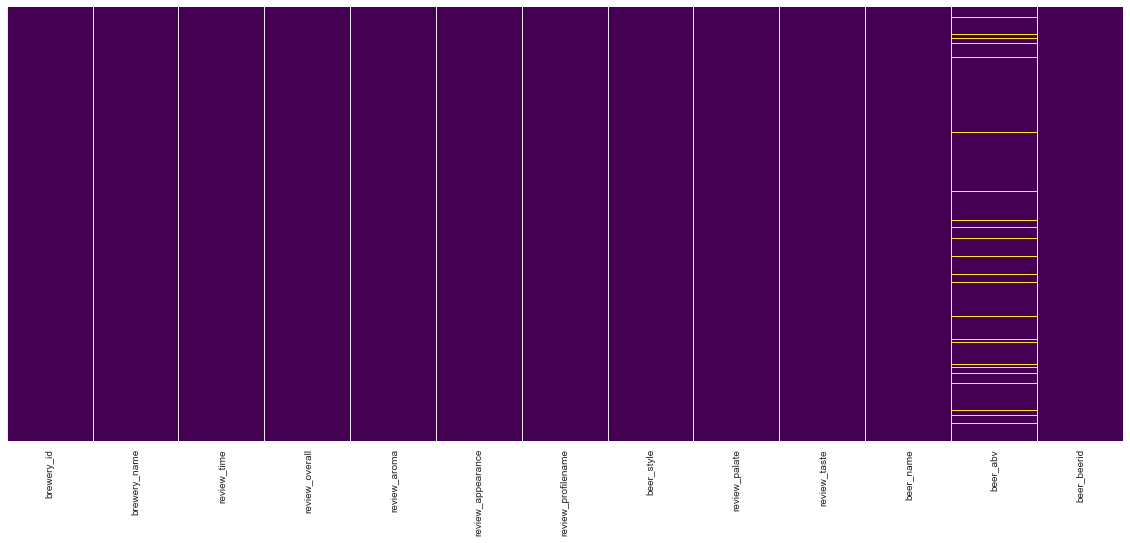

In [17]:
plt.figure(figsize= (20,8))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis');

List of object dtypes:

 ['brewery_name' 'review_profilename' 'beer_style' 'beer_name']


List of unrelevant columns that will be intially dropped

 ['review_profilename', 'review_time', 'brewery_name', 'beer_beerid']

The number of numeric variables is: 8


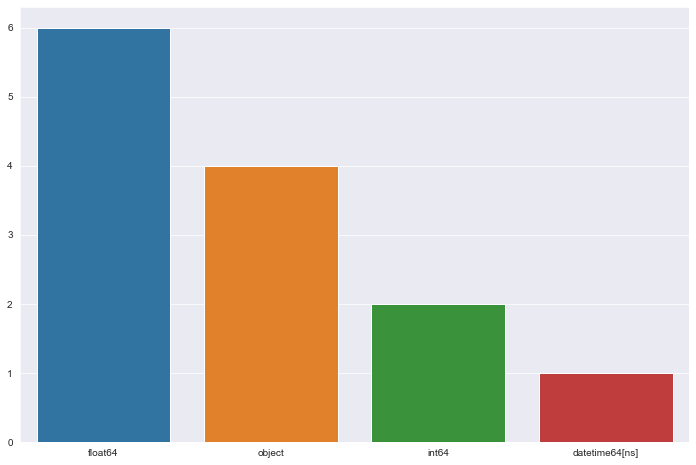

In [18]:
# Ploting the data types in the data set.
# We are concerned here with the object dtype, as sklearn takes only numeric data
data_type = df.dtypes.value_counts()
object_dtypes = df.columns[df.dtypes == object].values

plt.figure(figsize= (12,8))
sns.barplot(x = [str(i) for i in data_type.index], y = data_type.values);
print("List of object dtypes:\n\n",object_dtypes)
print("\n\nList of unrelevant columns that will be intially dropped\n\n",drop_columns)
print("\nThe number of numeric variables is:", len(df.columns[df.dtypes == 'float64']) + len(df.columns[df.dtypes == 'int64']))

### Drop Columns 

In [19]:
df = df.drop(drop_columns, axis = 1)

In [20]:
df.head()

,brewery_id,review_overall,review_aroma,review_appearance,beer_style,review_palate,review_taste,beer_name,beer_abv
0,10325,1.5,2.0,2.5,Hefeweizen,1.5,1.5,Sausa Weizen,5.0
1,10325,3.0,2.5,3.0,English Strong Ale,3.0,3.0,Red Moon,6.2
2,10325,3.0,2.5,3.0,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5
3,10325,3.0,3.0,3.5,German Pilsener,2.5,3.0,Sausa Pils,5.0
4,1075,4.0,4.5,4.0,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7


### Impute Null Values

In [21]:
df.isnull().sum()

brewery_id               0
review_overall           0
review_aroma             0
review_appearance        0
beer_style               0
review_palate            0
review_taste             0
beer_name                0
beer_abv             67785
dtype: int64

In [22]:
df.beer_abv.fillna(df.beer_abv.mean(),inplace=True)

In [23]:
df.isnull().sum()

brewery_id           0
review_overall       0
review_aroma         0
review_appearance    0
beer_style           0
review_palate        0
review_taste         0
beer_name            0
beer_abv             0
dtype: int64

## Categorical Features Encoding

In [24]:
categorical_vars = list(df.columns[df.dtypes == object].values)
categorical_vars

['beer_style', 'beer_name']

In [25]:
obj_df = df.select_dtypes(include=['object']).copy() #copy so u dont change the original df
obj_df.head()

,beer_style,beer_name
0,Hefeweizen,Sausa Weizen
1,English Strong Ale,Red Moon
2,Foreign / Export Stout,Black Horse Black Beer
3,German Pilsener,Sausa Pils
4,American Double / Imperial IPA,Cauldron DIPA


# Visualizations

In [26]:
# !pip install wordcloud

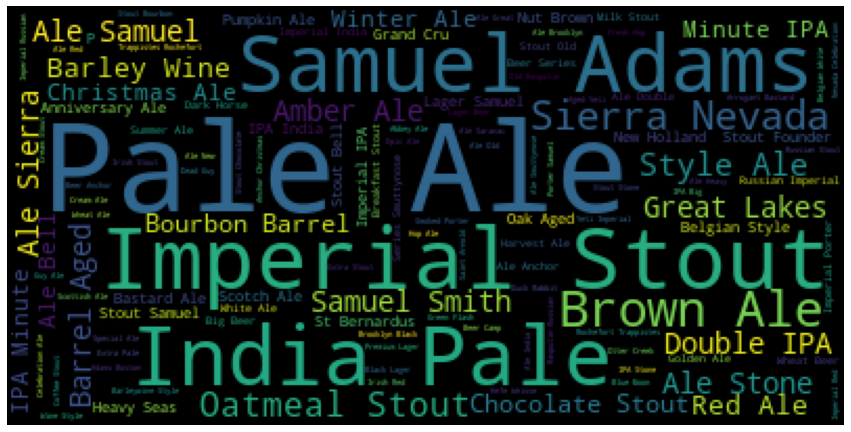

In [27]:
from wordcloud import WordCloud

# Beer Nmae
beer_name = df['beer_name']
beer_name = pd.DataFrame(beer_name)
beer_name.columns = ['Beer Name']
beer_name = beer_name.dropna(axis=0, how='all')
wordcloud = WordCloud().generate(' '.join(beer_name['Beer Name']))

# Generate plot
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('beer_rating_files/beer_name.png')
plt.show()

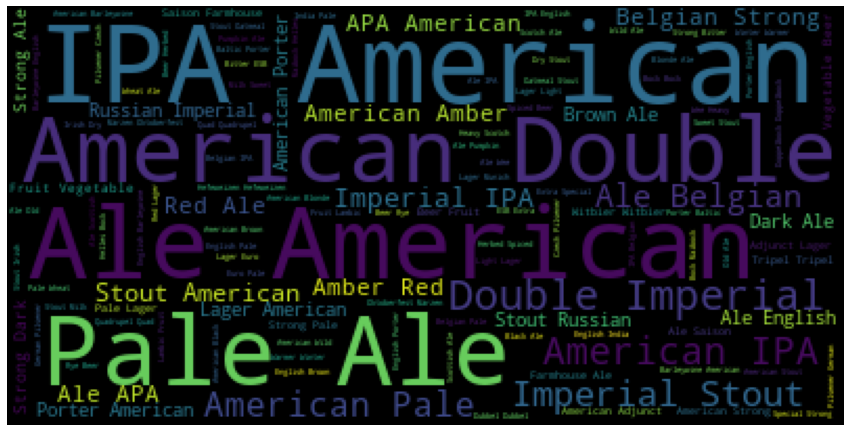

In [28]:
# Employee Title
beer_style = df['beer_style']
beer_style = pd.DataFrame(beer_style)
beer_style.columns = ['Beer Style']
beer_style = beer_style.dropna(axis=0, how='all')
wordcloud = WordCloud().generate(' '.join(beer_style['Beer Style']))

# Generate plot
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('beer_rating_files/beer_style.png')
plt.show()

<AxesSubplot:xlabel='review_overall', ylabel='Density'>

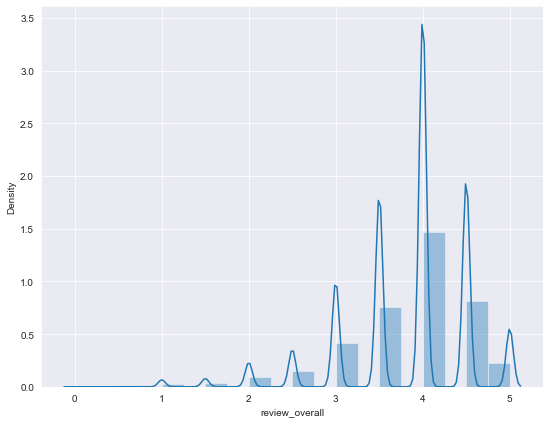

In [29]:
# Rating Distributions

plt.figure(figsize=(9,7))

sns.distplot(df['review_overall'],bins=20)

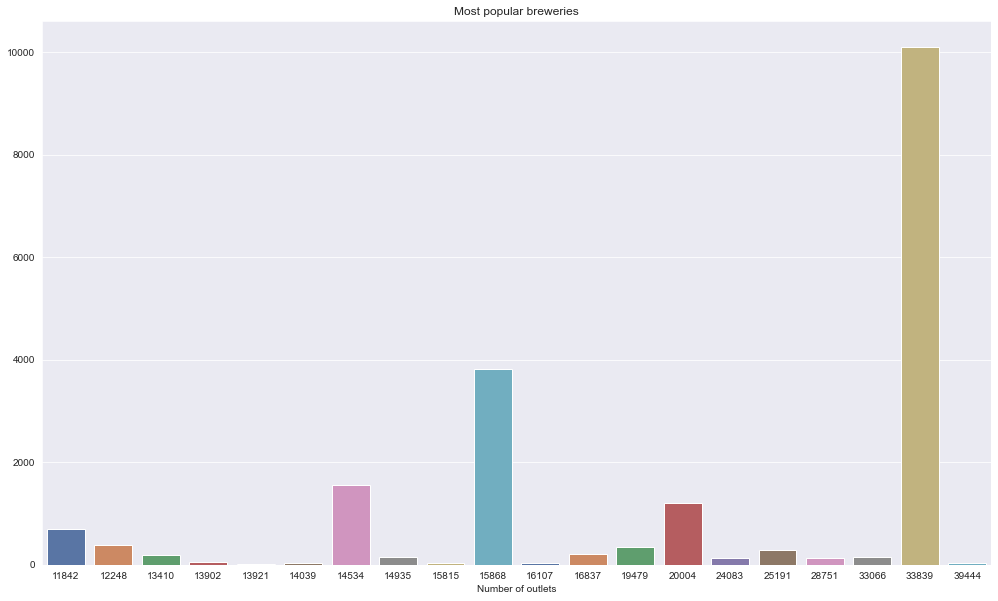

In [30]:
plt.figure(figsize=(17,10))
brewery=df['brewery_id'].value_counts()[:20]
sns.barplot(x=brewery,y=brewery.index,palette='deep')
plt.title("Most popular breweries")
plt.xlabel("Number of outlets")
plt.show()

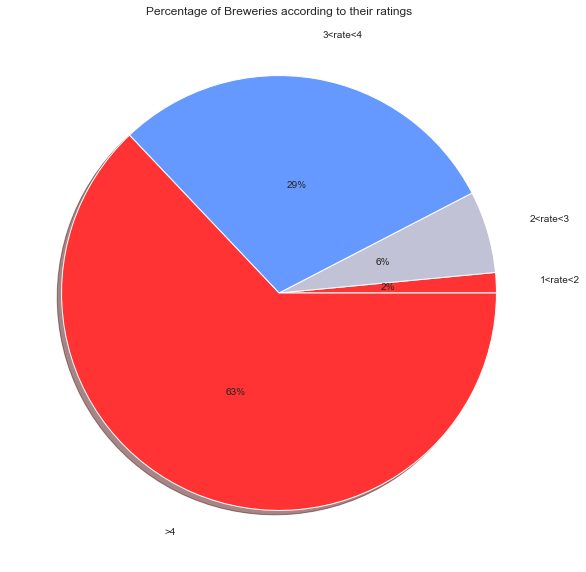

In [31]:
slices=[((df['review_overall']>=1) & (df['review_overall']<2)).sum(),
        ((df['review_overall']>=2) & (df['review_overall']<3)).sum(),
        ((df['review_overall']>=3) & (df['review_overall']<4)).sum(),
        (df['review_overall']>=4).sum()
        ]

labels=['1<rate<2','2<rate<3','3<rate<4','>4']
colors = ['#ff3333','#c2c2d6','#6699ff']
plt.pie(slices,colors=colors, labels=labels, autopct='%1.0f%%', pctdistance=.5, labeldistance=1.2,shadow=True)
fig = plt.gcf()
plt.title("Percentage of Breweries according to their ratings")

fig.set_size_inches(10,10)
plt.show()

#### Why we doing Label Encoding?
- We apply One-Hot Encoding when:

The categorical feature is not ordinal (like the countries above)
The number of categorical features is less so one-hot encoding can be effectively applied

- We apply Label Encoding when:

The categorical feature is ordinal (like Jr. kg, Sr. kg, Primary school, high school)
 The number of categories is quite large as one-hot encoding can lead to high memory consumption

In [32]:
map_dict = {col: {n: cat for n, cat in enumerate(obj_df[col].astype('category').cat.categories)} for col in obj_df}
obj_df = pd.DataFrame({col: obj_df[col].astype('category').cat.codes for col in obj_df}, index=obj_df.index)
obj_df.head(10)

,beer_style,beer_name
0,65,44426
1,51,41738
2,59,6887
3,61,44425
4,9,11359
5,66,10516
6,66,10516
7,66,10516
8,66,10516
9,66,10516


In [33]:
#save the categorical mappings if we want to convert back later#save the c
import json

with open('beer_rating_files/categorical_vars.json', 'w') as fp:
    json.dump(map_dict, fp)

In [34]:
df.drop(categorical_vars,axis=1,inplace=True) #drop transformed original features

In [35]:
#Finally!!
model_data= pd.concat([df.copy(), obj_df],axis=1)
model_data.shape

(1586614, 9)

In [36]:
model_data.head()

,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_style,beer_name
0,10325,1.5,2.0,2.5,1.5,1.5,5.0,65,44426
1,10325,3.0,2.5,3.0,3.0,3.0,6.2,51,41738
2,10325,3.0,2.5,3.0,3.0,3.0,6.5,59,6887
3,10325,3.0,3.0,3.5,2.5,3.0,5.0,61,44425
4,1075,4.0,4.5,4.0,4.0,4.5,7.7,9,11359


### Fix Y variable

In [37]:
df.value_counts('review_overall')
# drop 0, round them up 

review_overall
4.0    582764
4.5    324385
3.5    301817
3.0    165644
5.0     91320
2.5     58523
2.0     38225
1.5     12975
1.0     10954
0.0         7
dtype: int64

In [38]:
#making two bins, "excellent"(1) vs "not excellent"(0)
# cut_reviews = [0, 1]
# review_bins = [0, 4, 5.0]
# model_data['review_overall'] = pd.cut(model_data['review_overall'], bins=review_bins, labels= cut_reviews) 
model_data['review_overall'] = np.where(model_data['review_overall'] >= 4, 1, 0)
model_data.head()

,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_style,beer_name
0,10325,0,2.0,2.5,1.5,1.5,5.0,65,44426
1,10325,0,2.5,3.0,3.0,3.0,6.2,51,41738
2,10325,0,2.5,3.0,3.0,3.0,6.5,59,6887
3,10325,0,3.0,3.5,2.5,3.0,5.0,61,44425
4,1075,1,4.5,4.0,4.0,4.5,7.7,9,11359


In [39]:
model_data.review_overall.value_counts()

1    998469
0    588145
Name: review_overall, dtype: int64

In [40]:
model_data.to_csv('beer_rating_files/model_data.csv')

In [41]:
target = 'review_overall'
X = model_data.drop(target, axis = 1)
Y = model_data[target]

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state= 42)

In [43]:
from sklearn.preprocessing import MinMaxScaler
# Feature Scaling
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(X_train) #ONLY FIT to train data!!
scaled_test = scaler.transform(X_test)

In [44]:
import pickle
def save_model(model_name, model):
    '''
    model_name = name.pkl
    joblib.load('name.pkl')
    assign a variable to load model
    '''
    with open(str(model_name), 'wb') as f:
        pickle.dump(model, f)

In [45]:
#save scaling model
save_model('beer_rating_files/scaler.pkl',scaler)

In [46]:
logmodel = LogisticRegression(penalty='l2', solver='sag', max_iter=10)
logmodel.fit(scaled_train,y_train)
predictions_scaled = logmodel.predict(scaled_test)
print(classification_report(y_test,predictions_scaled))
print(logmodel.score(scaled_test, y_test))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77     59222
           1       0.84      0.90      0.87     99440

    accuracy                           0.84    158662
   macro avg       0.83      0.81      0.82    158662
weighted avg       0.83      0.84      0.83    158662

0.8351464118692566


In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
from IPython.display import display

THRESHOLD = [0.4,0.5,0.6,0.7,0.8]
for i in THRESHOLD:
    preds = np.where(logmodel.predict_proba(X_test)[:,1] > i, 1, 0)
    print(i)
    df_thresh = pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                       precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
                 index=["accuracy", "recall", "precision", "roc_auc_score"], columns = ["Scores"])
    display(df_thresh)

0.4


,Scores
accuracy,0.611123
recall,0.939994
precision,0.626469
roc_auc_score,0.499454


0.5


,Scores
accuracy,0.611104
recall,0.939964
precision,0.626462
roc_auc_score,0.499439


0.6


,Scores
accuracy,0.611047
recall,0.939853
precision,0.626443
roc_auc_score,0.499400


0.7


,Scores
accuracy,0.611028
recall,0.939763
precision,0.626445
roc_auc_score,0.499406


0.8


,Scores
accuracy,0.611003
recall,0.939632
precision,0.626451
roc_auc_score,0.499416


0.5 threshold remains best, not much change in testing diff thresholds

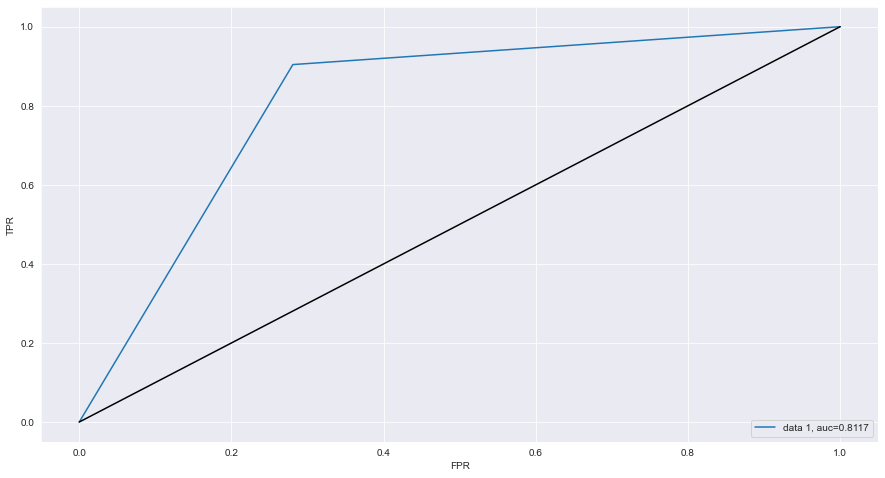

In [48]:
y_pred = logmodel.predict(scaled_test)
fpr, tpr, threshold = roc_curve(y_test,  y_pred)
auc = round(roc_auc_score(y_test, y_pred),4)
plt.figure(figsize=(15,8))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
x = np.linspace(0, 1, 100000)
plt.plot(x, x + 0, linestyle='solid',c = 'k')
plt.legend(loc=4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### Save model

In [49]:
logmodel.coef_

array([[ -0.05427688,   1.41277136,   1.33372864,   5.21105157,
          9.61572308, -10.71222453,  -0.12487454,   0.05637339]])

In [53]:
values = [1035, 1.5, 4.5, 2.5, 2.5, 5, 65, 44426]
logmodel.coef_[1:] * values

array([], shape=(0, 8), dtype=float64)

In [59]:
sum_values = np.sum(logmodel.coef_ * values)

In [62]:
np.exp(-sum_values) / (1 + np.exp(-sum_values))

0.0

In [48]:
save_model('beer_rating_files/logmodel.pkl',logmodel)

### Load model

In [49]:
logmodel = joblib.load('beer_rating_files/logmodel.pkl')

In [ ]:
#save csv to my google drive
# from google.colab import drive
# drive.mount('/drive')
# df.to_csv('/drive/My Drive/beerratings_edited.csv');
# pd.read_csv("drive/My Drive/beerratings_edited.csv")

In [66]:

#Preparing Extra Tree Regression
# from sklearn.ensemble import  ExtraTreesRegressor
# ET_Model=ExtraTreesRegressor(n_estimators = 120)
# ET_Model.fit(X_train,y_train)
# y_predict=ET_Model.predict(x_test)


# from sklearn.metrics import r2_score
# r2_score(y_test,y_predict)

KeyboardInterrupt: 

In [84]:
#Preparing Random Tree Regression
# from sklearn.ensemble import RandomForestRegressor
# RF_Model=RandomForestRegressor(n_estimators=650,random_state=245,min_samples_leaf=.0001)
# RF_Model.fit(X_train,y_train)
# y_predict=RF_Model.predict(X_test)
# r2_score(y_test,y_predict)

# **Linear Regression Model**

In [82]:
# linear_model = LinearRegression( normalize = True )

In [81]:
# X = df[[ 'review_aroma', 'review_appearance', 'review_palate', 'review_taste' ] ]
# y = df[ 'review_overall' ]
# linear_model.fit(X,y)

In [80]:
# training the model 

# preds = linear_model.predict(df[ [ 'review_aroma', 'review_appearance', 'review_palate', 'review_taste' ] ] )

In [79]:
# Coeffifients for each feature in X 
# linear_model.coef_

In [78]:
# # checking error in the model 
# # Based on a rule of thumb, it can be said that RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately.
# np.sqrt( mean_squared_error(df[ 'review_overall' ], preds ) )

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X,y,
#                                                     test_size=0.33, 
#                                                     random_state=42)
# X_test

# **Chelsea tries logistic regression**

In [ ]:
# #making two bins, "excellent" vs "not excellent"
# cut_reviews = ["Not Excellent", "Excellent"]
# review_bins = [0, 3.5, 5.0]
# df['excellent_reviews'] = pd.cut(df['review_overall'], bins=review_bins, labels= cut_reviews)
# df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,excellent_reviews
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986,Not Excellent
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213,Not Excellent
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215,Not Excellent
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969,Not Excellent
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883,Excellent


In [ ]:
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# label_encoder.fit()

In [77]:
# how to make the dummy variables

# reviews = {'Not Excellent': 0, 'Excellent': 1}
# df.excellent_reviews = df.excellent_reviews.map(reviews)
# df.head()

In [76]:
#  df['excellent_reviews'] = pd.get_dummies(df[['excellent_reviews']])
#  df.head()

In [ ]:
# from sklearn.linear_model           import LogisticRegression
# import numpy as np
# from sklearn                        import metrics, svm
# df['excellent_reviews'].value_counts()

1    998469
0    588138
Name: excellent_reviews, dtype: int64

In [75]:
# df_logistic = df.dropna()
# Y = df_logistic.excellent_reviews.values.reshape(-1, 1)
# x = df_logistic.beer_abv.values.reshape(-1, 1)


# print("Shape: ", x.shape, Y.shape)


In [ ]:
# x = df_logistic['beer_abv']
# Y = df_logistic['excellent_reviews']
# Y = df_logistic['excellent_reviews'].values.reshape(-1, 1)
# x = df_logistic['beer_abv'].values.reshape(-1, 1)

In [74]:
# from sklearn.linear_model import LogisticRegression
# from sklearn import metrics
# from sklearn.model_selection import train_test_split
# x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.33, random_state=42)
# logreg = LogisticRegression(multi_class='auto')
# logreg.fit(x_train, Y_train)

In [73]:
#code from Firas

# from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

# THRESHOLD = 0.50
# preds = np.where(logreg.predict_proba(x_test)[:,1] > THRESHOLD, 1, 0)

# pd.DataFrame(data=[accuracy_score(Y_test, Y_pred), recall_score(Y_test, Y_pred),
#                    precision_score(Y_test, Y_pred), roc_auc_score(Y_test, Y_pred)], 
#              index=["accuracy", "recall", "precision", "roc_auc_score"], columns = ["Scores"])
# 0.5 remained the best threshold

In [ ]:
# Y_pred = logreg.predict_proba(x_test)
# Y_pred = (Y_pred>0.7)
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, Y_test)))


In [72]:
# Y_pred[:5]
#if above .5 will choose that class

In [ ]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix = confusion_matrix(Y_test, Y_pred)
# print(confusion_matrix)

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(Y_test, Y_pred))

In [71]:
# def metrics(matrix):
#     TN = matrix[0,0]
#     FP = matrix[0,1]
#     FN = matrix[1,0]
#     TP = matrix[1,1]
#     FPR  = round(FP / (FP + TN), 4)
#     Confidence = round(1 - FPR, 4)
#     FDR = round(FP / (FP + TP), 4)
#     Precision = 1 - FDR
#     Recall_Power = round(TP / (TP + FN), 4)
#     Accuracy = round((TP + TN) / (TP +FP + TN + FN), 4)
#     return {'FPR':FPR, 'Confidence': Confidence, 'FDR' :FDR, 'Precision': Precision, 'Recall_Power':Recall_Power, 'Accuracy': Accuracy}

In [70]:
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# print(metrics(confusion_matrix(Y_test,Y_pred)))
# print("\n")
# print(classification_report(Y_test,Y_pred))
# print("\n")
# print(accuracy_score(Y_test,Y_pred))

In [69]:
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve
# logit_roc_auc = roc_auc_score(Y_test, logreg.predict(x_test))
# fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(x_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).